# Cutting-Edge project - Milliman


- Members: **Amal BACHA - Dalia BARBI - Khalil BATTIKH - Lucas RODRIGUEZ - Naïm SOUNI**
- Group 2
- Professional partner: **[Milliman](https://www.milliman.com/en/)**

*January 2023 - Present*

---

In [269]:
import numpy as np
import numpy.random as npr
import time
import warnings
import scipy
import random
import pandas as pd
import matplotlib.pyplot as plt
from enum import Enum

# Silencing all warnings for a better UX
warnings.filterwarnings("ignore")

# Setting up a fixed random seed for experiment purposes
npr.seed(1)

In [301]:
# Global variables & constants
_MAX_STEPS = int(1e5)

# Defining the available numerical schemes
Scheme = Enum('Scheme', ["EULER", "MILSTEIN"])

## Interest rates modelling

### Vasicek

In [238]:
# Function to explicitly cast a dictionary or Numpy array into a pandas DataFrame
cast_df = lambda x: pd.DataFrame(x)

In [344]:
class VasicekModel:
    def __init__(self, r0: float, kappa: float, theta: float, eta: float) -> None:
        """
        Default constructor in order to verify the validity of the parameters, and store them
        """
        # Verification
        assert r0 > 0 and kappa > 0 and theta > 0 and eta > 0
        
        # Storing variable
        self.r0 = r0
        self.kappa = kappa
        self.theta = theta
        self.eta = eta
        
    def __repr__(self) -> str:
        """
        Hard string representation
        """
        return f"Vasicek model (r0 = {self.r0}, kappa = {self.kappa}, theta = {self.theta}, eta = {self.eta})"
    
    def __str__(self) -> str:
        """
        Gentle string representation
        """
        return f"Vasicek model (r0 = {self.r0}, kappa = {self.kappa}, theta = {self.theta}, eta = {self.eta})"
  
    def get_parameter_string(self) -> str:
        """
        Function returning a user-friendly string displaying the model parameters values
        """
        return f"(r0 = {self.r0}, kappa = {self.kappa}, theta = {self.theta}, eta = {self.eta})"
    
    def simulate_path(self, scheme: Scheme = Scheme.EULER, **kwargs) -> dict:
        """
        Function wrapping the 2 available simulators to simulate 1 path
        """
        if scheme == Scheme.EULER:
            return self.simulate_euler(**kwargs)
        return self.simulate_milstein(**kwargs)
    
    def simulate_paths(self, M: int = 3, scheme: Scheme = Scheme.EULER, **kwargs) -> dict:
        """
        Function wrapping the 2 available simulators to simulate several paths
        """
        assert M >= 1 and type(M) == int
        
        res = []
        for m in range(1, M + 1):
            if scheme == Scheme.EULER:
                sim = self.simulate_euler(**kwargs)
                if m == 1:
                    res.append(sim["t"])
                res.append(sim["r"])
            elif scheme == Scheme.MILSTEIN:
                sim = self.simulate_euler(**kwargs)
                if m == 1:
                    res.append(sim["t"])
                res.append(sim["r"])
        return res
            
    def simulate_euler(self,
                       T: float = 1.0,
                       N: int = _MAX_STEPS) -> dict:
        """
        Function implementing a path simulator following Vasicek model dynamics
        using the Euler-Maruyama method
        Returns a dictionary (hashmap) with the time and generated rates columns
        """
        # Time step
        dT = T/float(N)

        # Generating the time horizon array
        H = np.arange(0, T, dT)

        # Generating the dW array
        dW = np.random.normal(0, 1, N)

        # Initializing the rates array
        r = np.zeros(N)
        r[0] = self.r0

        # Computing the rates
        for t in range(N - 1):
            r[t + 1] = r[t] + self.kappa*(self.theta - r[t])*dT + self.eta*dW[t]
        return {"t": H, "r":r}
        
    def simulate_milstein(self,
                          T: float = 1.0,
                          N: int = _MAX_STEPS) -> dict:
        """
        Function implementing a path simulator following Vasicek model dynamics
        using the Milstein method
        Returns a dictionary (hashmap) with the time and generated rates columns
        """
        # Since b'(.) = 0, the Milstein scheme is equivalent to the Euler scheme
        return self.simulate_euler(T, N)

In [345]:
# Default Vasicek model
model = VasicekModel(0.01875, 0.20, 0.01, 0.012)

In [346]:
# Casting the results into a pandas DataFrame
df = cast_df(model.simulate_euler(2))

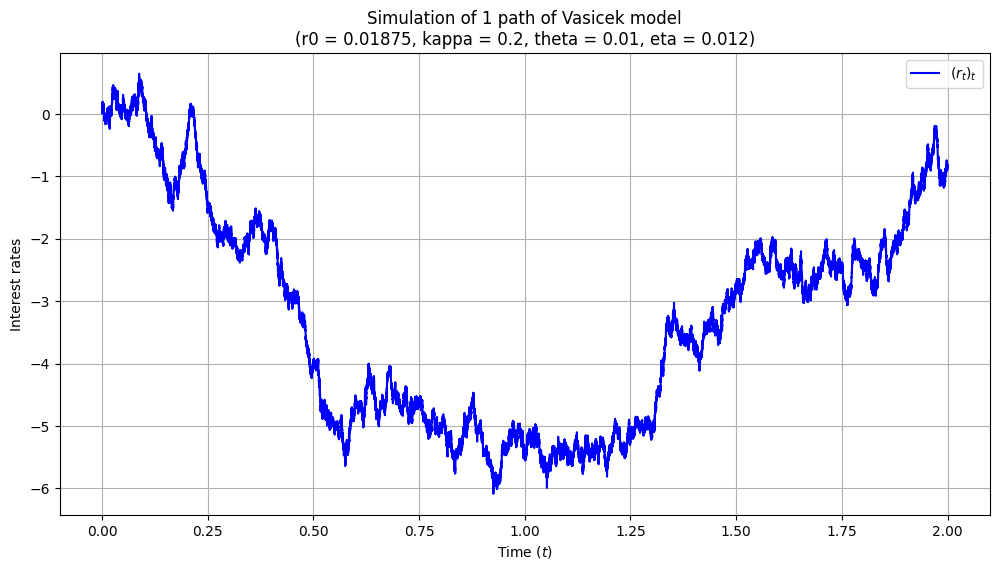

In [347]:
# Simulation of a trajectory
_ = df.plot(figsize=(12, 6), color="blue", x="t", y ="r", label="$(r_t)_t$")
_ = plt.grid()
_ = plt.xlabel("Time ($t$)")
_ = plt.ylabel("Interest rates")
_ = plt.title(f"Simulation of 1 path of Vasicek model\n{model.get_parameter_string()}")

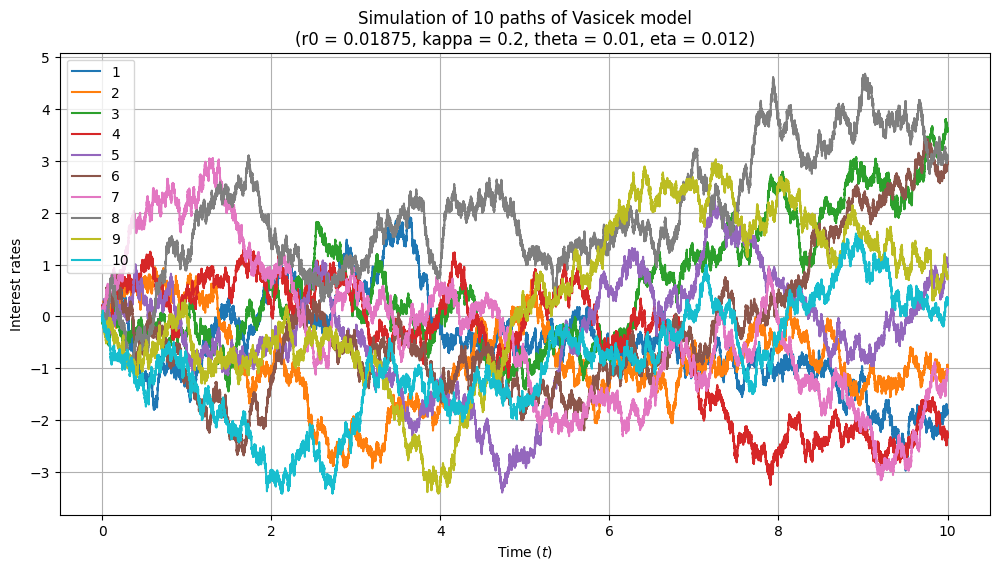

In [367]:
# Simulation of several trajectories
NB_TRAJECTORIES = 10
_ = cast_df(model.simulate_paths(NB_TRAJECTORIES, T = 10)).T.plot(x = 0, y = list(range(1, NB_TRAJECTORIES + 1)), figsize=(12, 6))
_ = plt.grid()
_ = plt.xlabel("Time ($t$)")
_ = plt.ylabel("Interest rates")
_ = plt.title(f"Simulation of {NB_TRAJECTORIES} paths of Vasicek model\n{model.get_parameter_string()}")

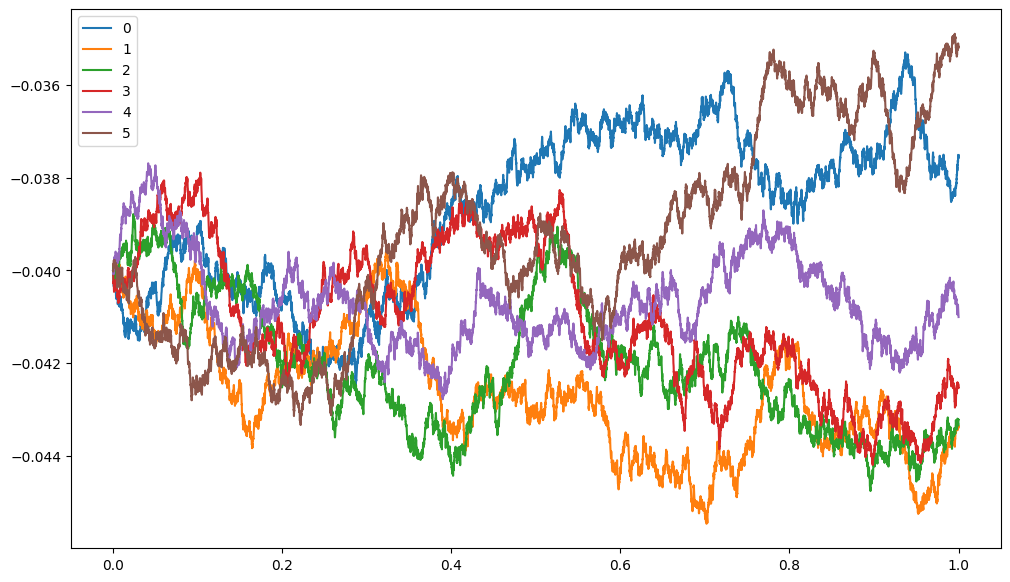

In [242]:
def OU_processes(years, timestep, num_sims, startRate, kappa, theta, sigma):
    """
    timestep has to be defined in years or a fraction of years
    e.g. 0.1 => 1/10th of a year; 2 => 2 years
    """
    times = np.arange(0,years+timestep,timestep)
    epsilon = np.random.normal(0, 1, (num_sims, len(times)-1))
    elt = 0.5 / kappa * (1.0 - np.exp (-2.0 * kappa * timestep))
    V = elt * sigma ** 2 
    sqrt_V = np.sqrt(V) 
    ou = np.zeros((num_sims, len(times)))
    ou[:,0] = startRate
    ou[:, 1:] = np.kron(sqrt_V, np.ones((num_sims, 1))) * epsilon
    for i in range(1, ou.shape[1]):
        ou[:, i] += theta * (1 - np.exp(-kappa * timestep))
        ou[:, i] += np.exp (-kappa * timestep) * ou[:, i-1]
    ou = pd.DataFrame(np.transpose(ou))
    ou.index = times
    return ou

_ = OU_processes(1, 1e-4, 6, -0.04, 1e-3, 2e-2, 0.005).plot(figsize=(12, 7))

In [90]:
# Vasicek (closed formula)

def sim_rates_vasicek_exact(m: VasicekModel = dftVasicek) -> np.ndarray:
    """  
    """
    pass

In [234]:
# Normality test (Shapiro-Wilk + Jarque-Bera)
TEST_THRESHOLD_ALPHA = 5e-2 # Threshold for p-value

# Definition of normality tests (Shapiro-Wilf + Jarque-Bera)
normtest_shapiro = lambda x: scipy.stats.shapiro(x).pvalue > TEST_THRESHOLD_ALPHA 
normtest_jarquebera = lambda x:scipy.stats.jarque_bera(x).pvalue > TEST_THRESHOLD_ALPHA

In [233]:
# Perform normality test

### Cox-Ingersoll-Ross (CIR)

In [71]:
class CIRModel:
    def __init__(self, r0: float, kappa: float, theta: float, sigma: float) -> None:
        """
        Default constructor in order to verify the validity of the parameters, and store them
        """
        # Verification
        assert r0 > 0 and kappa > 0 and theta > 0 and sigma > 0
        
        # Verifying the Feller condition
        feller_condition = 2*kappa*theta >= sigma**2
        if feller_condition:
            print("(r_t)_t strictly positive")
        
        # Storing variable
        self.r0 = r0
        self.kappa = kappa
        self.theta = theta
        self.eta = eta

### Hull & White (HW) $\diamond$ Extended Vasicek

## Equity modelling

### Black-Scholes model $\diamond$ <span style="background:red; color:white; padding: 2px 6px">Constant drift/Constant volatility</span>

### Black-Scholes model $\diamond$ <span style="background:red; color:white; padding: 2px 6px">Time-varying drift/Constant volatility</span>

### Black-Scholes model $\diamond$ <span style="background:red; color:white; padding: 2px 6px">Time-varying drift/Time-varying volatility</span>

## Analysis

### Distribution of $S_T$

### Computation of derivatives price

## Miscellaneous

### Simulation of the joint distribution $\Big(\int_0^T r_u \mathrm{d}u, S_T\Big) $

### Model refinement $\longrightarrow$ Constant to time-varying parameters

#### <u>Interest rates dynamics</u> $\leadsto$ <span style="background:gray; color:white; padding: 2px 6px">$t \longmapsto \theta(t)$ instead of $\theta \in \mathbb{R}^+$</span>

#### <u>Equity index dynamics</u> $\leadsto$ <span style="background:gray; color:white; padding: 2px 6px">$t \longmapsto \sigma(t)$ instead of $\sigma \in \mathbb{R}^+$</span>

---
**Amal BACHA - Dalia BARBI - Khalil BATTIKH - Lucas RODRIGUEZ - Naïm SOUNI**
